# ML4CV assignment


- Jana Nikolovska (jana.nikolovska@studio.unibo.it) \
13/11/2025
---
TODO: 🎰
- write a good **README**
- add visualizations
- add a section without the edge head
- go over it again, remove unneccessary comments
- remove `tta_hflip`
- add a section to download the test dataset
---

## 📦 Imports and Contants


In [33]:
import os
import json
import datetime
from pathlib import Path
from collections import Counter
import logging
import random
from typing import Iterable, Optional

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import LinearLR, SequentialLR, CosineAnnealingLR, CosineAnnealingWarmRestarts
from torch.cuda.amp import GradScaler

import torchvision
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from torchvision.models import resnet101, ResNet101_Weights
from torchvision.models._utils import IntermediateLayerGetter
from torchvision.models.segmentation.deeplabv3 import DeepLabV3, DeepLabHead




In [34]:
try:
  del model, train_loader, val_loader, test_open_loader, test_closed_loader
  torch.cuda.empty_cache()

  import torch

  if torch.cuda.is_available():
      print("Allocated:", round(torch.cuda.memory_allocated(0)/1024**2, 1), "MB")
      print("Cached:", round(torch.cuda.memory_reserved(0)/1024**2, 1), "MB")
except:
  print("Nothing deleted")

Allocated: 787.3 MB
Cached: 1890.0 MB


In [35]:
# Constants
TRAIN_ON = False #set TRAIN_ON=TRUE if you want to enable training, otherwise load weights

COLORS = np.array([
    [  0,   0,   0],  # unlabeled    =   0,
    [ 70,  70,  70],  # building     =   1,
    [190, 153, 153],  # fence        =   2,
    [250, 170, 160],  # other        =   3,
    [220,  20,  60],  # pedestrian   =   4,
    [153, 153, 153],  # pole         =   5,
    [157, 234,  50],  # road line    =   6,
    [128,  64, 128],  # road         =   7,
    [244,  35, 232],  # sidewalk     =   8,
    [107, 142,  35],  # vegetation   =   9,
    [  0,   0, 142],  # car          =  10,
    [102, 102, 156],  # wall         =  11,
    [220, 220,   0],  # traffic sign =  12,
    [ 60, 250, 240],  # anomaly      =  13,
])

BATCH_SIZE = 8
NUM_CLASSES = 13
NUM_EPOCHS = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

CLASS_NAMES = [
    "unlabeled", "building", "fence", "other", "pedestrian", "pole",
    "road line", "road", "sidewalk", "vegetation", "car", "wall",
    "traffic sign", "anomaly"
]

## 🧰 Helper Functions

Utility blocks for logging, visualizations, dataset manipulation, saving/loading models etc




*   Short-side **random scale + random crop** was introduced since the model was struggling on the small objects. I observed this by seeing multiple segmentation maps of the results
*   To make the model robust to **small changes data augmentations** like: **Horizontal flip** and **Mild color jitter** was added
*   I noticed during training (from the per-class mIoU) that some classes were performing much worse than others, so I added **class weighting** — using inverse frequency (with a square-root tempering) to give rare classes more importance and normalizing the weights so the overall loss scale stays balanced.

In [36]:
#Helper functions for visualization

def colors_to_rgb(mask_hw, colors: Iterable[Iterable[int]], ignore_index: int = 255) -> np.ndarray:
    """Convert a (H,W) mask of class IDs to an RGB np.uint8 array using a list/array of class colors."""
    # coerce inputs
    if torch.is_tensor(mask_hw):
        mask = mask_hw.detach().cpu().numpy().astype(np.int32)
    else:
        mask = np.asarray(mask_hw, dtype=np.int32)

    colors = np.asarray(colors, dtype=np.uint8)  # shape: (C, 3)
    h, w = mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)

    valid = (mask != ignore_index) & (mask >= 0) & (mask < len(colors))
    rgb[valid] = colors[mask[valid]]
    # optional: set ignored/out-of-range to neutral gray (change if you prefer black)
    rgb[~valid] = np.array([127, 127, 127], dtype=np.uint8)
    return rgb


def colorize_labels(mask_hw, colors: Iterable[Iterable[int]], ignore_index: int = 255) -> Image.Image:
    """Return a PIL RGB image from a (H,W) label mask using a colors list/array."""
    return Image.fromarray(colors_to_rgb(mask_hw, colors, ignore_index), mode="RGB")


def colorize_labels_from_path(label_path: str, colors: Iterable[Iterable[int]], ignore_index: int = 255) -> Image.Image:
    """Load a label image from disk and return a colorized PIL image using a colors list/array."""
    label_np = np.array(Image.open(label_path).convert("L"), dtype=np.int32)
    return colorize_labels(label_np, colors, ignore_index)

def plot_training_curves(history: dict, model_name: str = "seg_model"):
    """Plot loss components, mean IoU, and maxlogit stats from a history dict (keys optional)."""
    epochs = range(1, len(history.get("loss", [])) + 1)

    plt.figure(figsize=(18, 5))

    # Losses
    plt.subplot(1, 3, 1)
    if "loss" in history: plt.plot(epochs, history["loss"], label="Total Loss")
    if "ce_loss" in history: plt.plot(epochs, history["ce_loss"], label="CE Loss")
    if "dice_loss" in history: plt.plot(epochs, history["dice_loss"], label="Dice Loss")
    plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.title(f"{model_name} - Loss Curves")
    plt.legend(); plt.grid(True)

    # Mean IoU
    plt.subplot(1, 3, 2)
    if "mean_iou" in history: plt.plot(epochs, history["mean_iou"], label="Mean IoU")
    plt.xlabel("Epochs"); plt.ylabel("Mean IoU"); plt.title(f"{model_name} - Mean IoU")
    plt.legend(); plt.grid(True)

    # MaxLogit stats and low-confidence%
    plt.subplot(1, 3, 3)
    if "maxlogit_mean" in history: plt.plot(epochs, history["maxlogit_mean"], label="MaxLogit Mean")
    if "maxlogit_std" in history: plt.plot(epochs, history["maxlogit_std"], label="MaxLogit Std")
    for th, values in (history.get("low_conf_pct") or {}).items():
        plt.plot(epochs, values, label=f"% pixels < {th}", linestyle="--")
    plt.xlabel("Epochs"); plt.ylabel("MaxLogit / Low-Confidence %"); plt.title(f"{model_name} - MaxLogit Statistics")
    plt.legend(); plt.grid(True)

    plt.tight_layout(); plt.show()

    # Optional per-class IoU
    if history.get("per_class_iou"):
        per_class_iou = np.array(history["per_class_iou"])
        plt.figure(figsize=(12, 6))
        for cls in range(per_class_iou.shape[1]):
            plt.plot(epochs, per_class_iou[:, cls], label=f"Class {cls}")
        plt.xlabel("Epochs"); plt.ylabel("IoU"); plt.title(f"{model_name} - Per-Class IoU")
        plt.legend(); plt.grid(True); plt.show()


def pretty_print_ious(
    per_class_iou,
    class_names: list[str] | None = None,
    anomaly_id: int | None = None,
    sort: bool = False,
    decimals: int = 3,
):
    """Print a per-class IoU table with optional sorting, names, and anomaly highlighting."""
    ious = np.array(per_class_iou, dtype=float)
    n_classes = len(ious)
    class_names = class_names or [f"class_{i}" for i in range(n_classes)]

    rows = list(zip(range(n_classes), class_names, ious))
    if sort:
        rows.sort(key=lambda x: x[2], reverse=True)

    print("\n📊 Per-Class IoU Summary:")
    print("-" * 50)
    print(f"{'ID':<3} {'Class Name':<20} {'IoU':>8}")
    print("-" * 50)
    for idx, name, val in rows:
        tag = "⚠️ anomaly" if (anomaly_id is not None and idx == anomaly_id) else ""
        print(f"{idx:<3} {name:<20} {val:>8.{decimals}f} {tag}")
    print("-" * 50)
    print(f"Mean IoU: {np.nanmean(ious):.{decimals}f}\n")


@torch.no_grad()
def save_seg_viz_batch(
    images: torch.Tensor,                     # (B,3,H,W) in [0,1] after denorm_fn or raw ToTensor before
    preds: torch.Tensor,                      # (B,H,W) int class ids
    *,
    gts: torch.Tensor | None = None,          # (B,H,W) optional
    maxlogit: torch.Tensor | None = None,     # (B,H,W) optional, for OOD heat overlay
    denorm_fn=None,                           # e.g., lambda x: denorm(x, MEAN, STD)
    colors: Iterable[Iterable[int]] | None = None,  # class colors (C,3), uint8-ish
    anomaly_id: int | None = None,            # if set with maxlogit, show OOD heat
    ignore_index: int = 255,
    save_dir: str = "./pred_viz",
    prefix: str = "",
    dpi: int = 110,
):
    """Save side-by-side panels (image, GT, prediction, optional OOD heat) for a batch."""
    os.makedirs(save_dir, exist_ok=True)
    B, C, H, W = images.shape

    for i in range(B):
        img = images[i].detach()
        if denorm_fn is not None:
            img = denorm_fn(img)
        img_np = img.clamp(0, 1).permute(1, 2, 0).cpu().numpy()

        pred_np = preds[i].detach().cpu().numpy().astype(np.int32)
        pred_rgb = None
        gt_rgb = None

        if colors is not None:
            pred_rgb = colors_to_rgb(pred_np, colors, ignore_index)
            if gts is not None:
                gt_np = gts[i].detach().cpu().numpy().astype(np.int32)
                gt_rgb = colors_to_rgb(gt_np, colors, ignore_index)

        # layout
        show_gt = gts is not None
        show_ood = (maxlogit is not None) and (anomaly_id is not None)
        ncols = 1 + int(show_gt) + 1 + int(show_ood)  # image + (GT) + pred + (OOD)
        fig, axes = plt.subplots(1, ncols, figsize=(4 * ncols, 4), dpi=dpi)
        if ncols == 1:
            axes = [axes]

        col = 0
        axes[col].imshow(img_np); axes[col].set_title("Image"); axes[col].axis("off"); col += 1

        if show_gt:
            if gt_rgb is None:  # fallback
                gt_np = gts[i].detach().cpu().numpy().astype(np.int32)
                gt_rgb = colors_to_rgb(gt_np, colors if colors is not None else [[0,0,0]], ignore_index)
            axes[col].imshow(gt_rgb); axes[col].set_title("GT"); axes[col].axis("off"); col += 1

        if pred_rgb is None:
            pred_rgb = colors_to_rgb(pred_np, colors if colors is not None else [[0,0,0]], ignore_index)
        axes[col].imshow(pred_rgb); axes[col].set_title("Pred"); axes[col].axis("off"); col += 1

        if show_ood:
            ml = maxlogit[i].detach().cpu().numpy()
            ml_norm = (ml - ml.min()) / (ml.max() - ml.min() + 1e-6)
            axes[col].imshow(img_np)
            im = axes[col].imshow(1.0 - ml_norm, alpha=0.5)  # darker = more OOD-like
            axes[col].set_title("1 - MaxLogit (OOD heat)"); axes[col].axis("off")
            fig.colorbar(im, ax=axes[col], fraction=0.046, pad=0.04)

        fname = f"{prefix}_{i:05d}.png" if prefix else f"{i:05d}.png"
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, fname))
        plt.close(fig)


In [5]:
#Helper functions for dataset

def denorm(img_tensor: torch.Tensor, mean=IMAGENET_MEAN, std=IMAGENET_STD) -> torch.Tensor:
    """Undo normalization on a [3,H,W] tensor using mean/std and clamp to [0,1]."""
    m = torch.tensor(mean, device=img_tensor.device)[:, None, None]
    s = torch.tensor(std,  device=img_tensor.device)[:, None, None]
    return (img_tensor * s + m).clamp(0, 1)


def process_folder(folder: str, verbose: bool = False):
    """Scan <folder>/images & <folder>/annotations and return [(fname, img_path, ann_path), ...]."""
    if verbose:
        print(f"Processing folder {folder}")

    images_folder = os.path.join(folder, "images")
    annotations_folder = os.path.join(folder, "annotations")
    exts = {".png", ".jpg", ".jpeg"}
    data = []

    for root, _, files in os.walk(images_folder):
        for image_file in files:
            if os.path.splitext(image_file)[1].lower() in exts:
                relative_path = os.path.relpath(root, images_folder)
                image_path = os.path.join(root, image_file)
                annotation_file = os.path.splitext(image_file)[0] + ".png"  # annotate as .png
                annotation_path = os.path.join(annotations_folder, relative_path, annotation_file)

                if os.path.exists(annotation_path):
                    data.append((image_file, image_path, annotation_path))
                else:
                    print(f"Warning: No annotation found for {image_file}")

    if verbose:
        print(f"Loaded {len(data)} image-annotation pairs.")
    return data


def pil_to_long_tensor(pic: Image.Image) -> torch.Tensor:
    """Convert PIL (L) image to torch.LongTensor [H,W]."""
    return torch.from_numpy(np.array(pic, dtype=np.int64))


class RandomShortSideScaleCrop:
    """Randomly scale to target short side, then random crop to (crop_size,crop_size), with padding if needed."""

    def __init__(self, base_size=768, scale_range=(0.5, 2.0), crop_size=512, retries=10):
        self.base_size = int(base_size)
        self.scale_range = scale_range
        self.crop_size = int(crop_size)
        self.retries = int(retries)

    def _scaled_wh(self, w: int, h: int) -> tuple[int, int]:
        """Compute resized (W,H) keeping aspect given a sampled short-side target."""
        short = min(w, h)
        scale = random.uniform(*self.scale_range)
        target_short = max(1, int(self.base_size * scale))
        ratio = target_short / max(1, short)
        W = max(1, int(round(w * ratio)))
        H = max(1, int(round(h * ratio)))
        return W, H

    def __call__(self, img: Image.Image, ann: Image.Image) -> tuple[Image.Image, Image.Image]:
        """Apply paired resize+pad+random-crop; keeps ann label IDs intact."""
        assert img.size == ann.size, "Image and annotation must have same size before transform."
        w, h = img.size

        # scale
        W, H = self._scaled_wh(w, h)
        img = img.resize((W, H), Image.BILINEAR)
        ann = ann.resize((W, H), Image.NEAREST)

        cs = self.crop_size

        # pad to crop if necessary (pad right/bottom for simplicity)
        pad_w = max(0, cs - W)
        pad_h = max(0, cs - H)
        if pad_w or pad_h:
            img = transforms.functional.pad(img, (0, 0, pad_w, pad_h), fill=0)
            ann = transforms.functional.pad(ann, (0, 0, pad_w, pad_h), fill=255)
            W, H = img.size

        # try a few random crops that include some labels (not only ignore=255)
        for _ in range(self.retries):
            x0 = random.randint(0, W - cs)
            y0 = random.randint(0, H - cs)
            ann_crop = ann.crop((x0, y0, x0 + cs, y0 + cs))
            if np.any(np.array(ann_crop) != 255):
                img = img.crop((x0, y0, x0 + cs, y0 + cs))
                ann = ann_crop
                break
        else:
            img = img.crop((0, 0, cs, cs))
            ann = ann.crop((0, 0, cs, cs))

        return img, ann


class SegmentationDataset(Dataset):
    """Paired image/annotation dataset with joint geom transforms and optional jitters."""

    def __init__(
        self,
        data,
        image_transform=None,
        annotation_transform=None,
        ignore_index=255,
        img_size=512,
        jitter=True,
        max_retry=8,
        base_size=768,
        scale_range=(0.5, 2.0),
    ):
        self.data = data
        self.ignore_index = ignore_index
        self.max_retry = max_retry

        # default paired pipeline
        if image_transform is None and annotation_transform is None:
            self.paired_geom = [
                RandomShortSideScaleCrop(
                    base_size=base_size,
                    scale_range=scale_range if jitter else (0.75, 1.25),
                    crop_size=img_size,
                    retries=10,
                )
            ]
            self.do_flip = bool(jitter)
            self.color_jitter = transforms.ColorJitter(
                brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1
            ) if jitter else None

            self.image_post = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
            ])
            self.annotation_post = transforms.Lambda(pil_to_long_tensor)
        else:
            # user-specified transforms
            self.paired_geom = []
            self.do_flip = False
            self.color_jitter = None
            self.image_post = image_transform or transforms.ToTensor()
            self.annotation_post = annotation_transform or transforms.Lambda(pil_to_long_tensor)

    def __len__(self) -> int:
        """Return dataset length."""
        return len(self.data)

    def __getitem__(self, idx: int):
        """Load, transform, and return (image_tensor, label_long) for index."""
        tries = 0
        N = len(self.data)

        while tries < self.max_retry:
            image_file, image_path, annotation_path = self.data[idx]
            try:
                with Image.open(image_path) as img:
                    img = img.convert("RGB").copy()
                with Image.open(annotation_path) as ann:
                    ann = ann.convert("L").copy()

                # paired geometric transforms
                for t in self.paired_geom:
                    img, ann = t(img, ann)

                # optional random horizontal flip (paired)
                if self.do_flip and random.random() < 0.5:
                    img = transforms.functional.hflip(img)
                    ann = transforms.functional.hflip(ann)

                # photometric jitter (image only)
                if self.color_jitter is not None:
                    img = self.color_jitter(img)

                # to tensor / normalize / int mask
                img = self.image_post(img)      # (3,H,W), float
                ann = self.annotation_post(ann) # (H,W), long

                # shift labels: 1..K -> 0..K-1 (preserve ignore_index)
                if self.ignore_index is not None:
                    ignore_mask = (ann == self.ignore_index)
                    ann = torch.where(ignore_mask, ann, ann - 1)
                else:
                    ann = ann - 1

                # clamp to avoid negatives after shift
                ann = torch.clamp(ann, min=0)

                return img, ann

            except (OSError, ValueError) as e:
                print(f"[Dataset] Skipping corrupted file: {image_file}. Error: {e}")
                idx = (idx + 1) % N
                tries += 1

        raise RuntimeError(f"[Dataset] Too many corrupted files in a row (>{self.max_retry}).")


def create_segmentation_datasets(train_data, val_data, test_open_data, test_closed_data, img_size=512):
    """Build train/val/test (open/closed) SegmentationDataset instances with consistent settings."""
    train_dataset = SegmentationDataset(train_data, img_size=img_size, jitter=True)
    val_dataset   = SegmentationDataset(val_data,   img_size=img_size, jitter=False)
    test_open_dataset   = SegmentationDataset(test_open_data,   img_size=img_size, jitter=False)
    test_closed_dataset = SegmentationDataset(test_closed_data, img_size=img_size, jitter=False)
    return train_dataset, val_dataset, test_open_dataset, test_closed_dataset


def get_dataloaders(train_dataset, val_dataset, test_open_dataset, test_closed_dataset, batch_size=4, num_workers=0):
    """Create DataLoaders with sane defaults; uses persistent workers only if num_workers > 0."""
    use_cuda = torch.cuda.is_available()
    pin = use_cuda
    persist = (num_workers > 0)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin,
        persistent_workers=persist,
        drop_last=False,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin,
        persistent_workers=persist,
    )

    test_open_loader = DataLoader(
        test_open_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin,
        persistent_workers=persist,
    )

    test_closed_loader = DataLoader(
        test_closed_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin,
        persistent_workers=persist,
    )
    return train_loader, val_loader, test_open_loader, test_closed_loader


@torch.no_grad()
def _minmax_per_image(x_bhw: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    """Per-image min–max normalize a (B,H,W) tensor to [0,1]."""
    x_min = x_bhw.amin(dim=(1, 2), keepdim=True)
    x_max = x_bhw.amax(dim=(1, 2), keepdim=True)
    return (x_bhw - x_min) / (x_max - x_min + eps)



In [6]:
# Model helper functions

def setup_logger(model_name: str, timestamp: str) -> logging.Logger:
    """Create a file logger named <model_name> writing to '<model>_<timestamp>.log'."""
    log_path = f"{model_name}_{timestamp}.log"
    logger = logging.getLogger(model_name)
    logger.setLevel(logging.INFO)
    logger.propagate = False

    if logger.handlers:
        for h in list(logger.handlers):
            logger.removeHandler(h)

    fh = logging.FileHandler(log_path)
    fh.setLevel(logging.INFO)
    fh.setFormatter(logging.Formatter("%(asctime)s - %(message)s"))
    logger.addHandler(fh)
    return logger

def load_model_and_history(
    model,
    load_dir: str | Path,
    model_name: str = "seg_model",
    device: Optional[torch.device | str] = None,
    map_location: Optional[torch.device | str] = None,
):
    """Load model weights (<name>.pth) and training history (<name>_history.json) from a folder."""
    load_dir = Path(load_dir)
    weights_path = load_dir / f"{model_name}.pth"
    history_path = load_dir / f"{model_name}_history.json"

    # Map location defaults: given map_location, else given device, else 'cpu'
    if map_location is None:
        map_location = device if device is not None else "cpu"

    state = torch.load(weights_path, map_location=map_location)
    model.load_state_dict(state)
    if device is not None:
        model = model.to(device)
    print(f"✅ Loaded model weights from → {weights_path}")

    if history_path.exists():
        with open(history_path, "r") as f:
            history = json.load(f)
        print(f"✅ Loaded training history from → {history_path}")
    else:
        print("⚠️ No history file found; returning empty dict.")
        history = {}

    return model, history


def save_model_and_history(
    model,
    history: dict,
    save_dir: str | Path,
    model_name: str = "seg_model",
) -> None:
    """Save model state_dict to <name>.pth and JSON-serializable training history to <name>_history.json."""
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)

    # weights
    weights_path = save_dir / f"{model_name}.pth"
    torch.save(model.state_dict(), weights_path)

    # history -> JSON-safe
    def make_json_safe(obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, np.generic):
            return obj.item()
        if isinstance(obj, dict):
            return {k: make_json_safe(v) for k, v in obj.items()}
        if isinstance(obj, (list, tuple)):
            return [make_json_safe(v) for v in obj]
        return obj

    safe_history = make_json_safe(history)

    history_path = save_dir / f"{model_name}_history.json"
    with open(history_path, "w") as f:
        json.dump(safe_history, f, indent=4)

    print(f"✅ Saved model weights → {weights_path}")
    print(f"✅ Saved training history → {history_path}")



### 🟩 Trimap IoU (Edge-Focused Intersection-over-Union)

**Trimap IoU** (also called *boundary IoU* or *edge-band IoU*) is a metric that focuses only on the pixels **around the object boundaries** instead of evaluating the entire segmentation mask.

In standard IoU, we measure overlap between the predicted and ground-truth regions across the **whole image**:

\[
\text{I\oU} = \frac{|\text{Prediction} \cap \text{GroundTruth}|}{|\text{Prediction} \cup \text{GroundTruth}|}
\]

However, many segmentation models already achieve near-perfect performance on large uniform regions (like background or big objects). The hardest and most meaningful errors often occur **along the edges** — where the predicted mask boundary doesn’t align precisely with the ground truth.

To capture that, Trimap IoU evaluates IoU **only inside a narrow band** (called the *trimap*) surrounding each ground-truth boundary.

#### How it works

1. Compute the **edges** of the ground-truth mask.  
2. **Dilate** those edges by a few pixels (typically 3–5) to form a thin band — the **trimap**.  
3. Evaluate IoU **only within that band**:
   \[
   \text{Trimap IoU} = \frac{|\text{Prediction} \cap \text{GroundTruth}|\_\text{within band}}{|\text{Prediction} \cup \text{GroundTruth}|\_\text{within band}}
   \]

This highlights how well the model aligns its **object boundaries**, independent of large-area accuracy.

#### Why use it?

- Detects **boundary quality** and alignment issues missed by full-image IoU.  
- More sensitive to over/under-segmentation near edges.  
- Useful for **high-precision tasks** like medical segmentation, autonomous driving, or fine object masks.

#### Example visualization

If `band_px=3`, only pixels within ~3 pixels of the true object edges are considered:



## 🏗️ Model Architecture

### ⏱️ Early Stopping
A validation-score based early stop with checkpointing.


In [42]:
class EarlyStopping:
    """Track best score and stop after `patience` non-improving epochs (saves best weights)."""
    def __init__(self, patience=5, delta=0.0, path="best_model.pth"):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.path = path

    def __call__(self, score, model):
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f"⚠️ EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)
        print(f"✅ Model improved. Saved to {self.path}")


### 🧩 Model Heads (Edge + DeepLabV3+ Decoder)
Uses ResNet-101 OS=8, fuses low-level features, and adds an auxiliary edge head.




*   OS=8 preserves 1/8 spatial detail at high receptive field (coarse strides (like 16/32) would blur or lose them)

**DeepLabV3+ decoder:**

  *  **ASPP** (applies parallel atrous (dilated) convolutions with different dilation rates (12, 24, 36)): multi-scale context
aggregation

  *  **Low-level feature skip** (from early in the backbone — layer1 in ResNet). This is an improvement from DeepLabV3. Early layers capture edges, corners, and textures, what the model had been struggling with.

**Auxiliary edge head:**

DeepLabV3+ fuses high-level (semantic) and low-level (spatial) features — but it still tends to smooth over fine boundaries or merge nearby objects if they touch or are very thin. In order to solve this I introduced a **edge auxiliary head**. The **auxiliary edge head** takes mid-level features from ResNet’s layer2, processes them through a small convolutional block, and is trained with a binary edge map (from ground-truth masks) to predict object boundaries—its goal is to guide the backbone to preserve edge information




In [43]:
class EdgeHead(nn.Module):
    """Light edge-detector head over intermediate features (e.g., ResNet layer2)."""
    def __init__(self, in_ch=512):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1),
            nn.Conv2d(256, 1, kernel_size=1)
        )
    def forward(self, x):
        return self.block(x)


class DeepLabV3PlusHead(nn.Module):
    """ASPP on high-level features + low-level fuse; outputs stride 4 logits."""
    def __init__(self, in_ch=2048, low_ch=256, num_classes=21):
        super().__init__()
        self.aspp = ASPP(in_ch, atrous_rates=[12, 24, 36])
        self.reduce_low = nn.Sequential(
            nn.Conv2d(low_ch, 48, kernel_size=1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True),
        )
        self.fuse = nn.Sequential(
            nn.Conv2d(256 + 48, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1),
            nn.Conv2d(256, num_classes, kernel_size=1)
        )

    def forward(self, x_out, x_low):
        x = self.aspp(x_out)                                       # (B,256,H/8,W/8)
        x = F.interpolate(x, scale_factor=2, mode="bilinear", align_corners=False)  # -> stride 4
        low = self.reduce_low(x_low)                                # (B,48,H/4,W/4)
        x = torch.cat([x, low], dim=1)
        return self.fuse(x)                                         # (B,C,H/4,W/4)


def get_model(num_classes: int):
    """Build OS=8 ResNet101 backbone with DeepLabV3+ head and auxiliary edge head."""
    backbone = resnet101(
        weights=ResNet101_Weights.DEFAULT,
        replace_stride_with_dilation=[False, True, True]  # OS=8
    )
    return_layers = {"layer4": "out", "layer1": "low", "layer2": "aux"}
    backbone = IntermediateLayerGetter(backbone, return_layers=return_layers)

    class Model(nn.Module):
        def __init__(self, num_classes):
            super().__init__()
            self.backbone = backbone
            self.decoder = DeepLabV3PlusHead(in_ch=2048, low_ch=256, num_classes=num_classes)
            self.aux_classifier = EdgeHead(in_ch=512)

        def forward(self, x):
            feats = self.backbone(x)
            out = self.decoder(feats["out"], feats["low"])
            out = F.interpolate(out, size=x.shape[-2:], mode="bilinear", align_corners=False)
            aux = self.aux_classifier(feats["aux"])
            return {"out": out, "aux": aux}

    return Model(num_classes)


### 🎯 Losses
Dice and a CE+Dice combo for segmentation training.


$$
\text{Total Loss} = (\mathcal{L}_{CE} + 2 \times \mathcal{L}_{Dice}) + 0.5 \times \mathcal{L}_{EdgeBCE}
$$

- CE ensures strong **per-pixel classification** and stable training.
- Dice aligns **regions and boundaries**, improving overlap for **small, thin, or rare classes**.
- **Edge BCE with pos_weight**: edge pixels are sparse; positive weighting prevents the edge head from collapsing to “all background” and focuses learning on actual boundaries (*auxiliary loss for the edge head of your model*)

CE stabilizes per-pixel logits; Dice aligns regions—this combo reliably boosts mean IoU and small classes.

- **Label smoothing** (optional): reduces over-confidence and helps when labels are a bit noisy at boundaries.



In [46]:
def compute_class_weights_from_loader(
    loader,
    num_classes: int,
    ignore_index: int = 255,
    max_batches: Optional[int] = None,
) -> torch.Tensor:
    """Compute inverse-frequency class weights from a label DataLoader (mean≈1 normalization)."""
    counts = torch.zeros(num_classes, dtype=torch.long)
    processed = 0

    print(f"Dataset size: {len(loader.dataset)}")
    print(f"Batch size: {loader.batch_size}")
    print(f"Number of batches: {len(loader)}")

    for _, ann in loader:
        # [B,H,W] or [B,1,H,W] -> [B,H,W]
        if ann.dim() == 4 and ann.shape[1] == 1:
            ann = ann.squeeze(1)

        valid = ann[ann != ignore_index].reshape(-1)
        if valid.numel() > 0:
            binc = torch.bincount(valid, minlength=num_classes)
            counts += binc[:num_classes].cpu()

        processed += 1
        if max_batches is not None and processed >= max_batches:
            break

    counts = counts.clamp_min(1)
    total = counts.sum().item()
    weights = total / (counts.float() * num_classes)         # inverse frequency
    weights = weights * (num_classes / weights.sum())        # normalize mean ≈ 1
    return weights

def sobel_edges_from_labels(labels, num_classes=None, ignore_index=255, dilate=1, thresh=1e-4):
    """Return (B,1,H,W) edge mask from label IDs via per-class Sobel magnitude (ignored→0)."""
    if not torch.is_tensor(labels):
        labels = torch.as_tensor(labels)
    if labels.dim() == 2:
        labels = labels.unsqueeze(0)
    labels = labels.long()
    device = labels.device
    B, H, W = labels.shape
    valid = (labels != ignore_index)
    if valid.sum().item() == 0:
        return torch.zeros((B,1,H,W), device=device, dtype=torch.float32)

    safe = labels.clone(); safe[~valid] = 0
    if num_classes is None or int(num_classes) <= 0:
        num_classes = int(safe.max().item() + 1)
    C = int(num_classes)

    onehot = torch.zeros(B, C, H, W, device=device, dtype=torch.float32)
    onehot.scatter_(1, safe.unsqueeze(1), 1.0)
    onehot *= valid.unsqueeze(1).float()

    kx = torch.tensor([[1,0,-1],[2,0,-2],[1,0,-1]], dtype=torch.float32, device=device).view(1,1,3,3).repeat(C,1,1,1)
    ky = torch.tensor([[1,2,1],[0,0,0],[-1,-2,-1]], dtype=torch.float32, device=device).view(1,1,3,3).repeat(C,1,1,1)

    gx = F.conv2d(onehot, kx, padding=1, groups=C)
    gy = F.conv2d(onehot, ky, padding=1, groups=C)
    g  = torch.sqrt(gx*gx + gy*gy)
    gsum = g.sum(dim=1, keepdim=True)
    edges = (gsum > thresh).float()
    edges *= valid.unsqueeze(1).float()

    if dilate and int(dilate) > 0:
        for _ in range(int(dilate)):
            edges = F.max_pool2d(edges, kernel_size=3, stride=1, padding=1)
    return edges


class DiceLoss(nn.Module):
    """Multi-class soft Dice loss with ignore support."""
    def __init__(self, smooth=1e-6, ignore_index=255):
        super().__init__()
        self.smooth = smooth
        self.ignore_index = ignore_index
    def forward(self, logits, targets):
        probs = torch.softmax(logits, dim=1)
        valid = (targets != self.ignore_index)
        safe_targets = targets.clone(); safe_targets[~valid] = 0
        targets_one_hot = torch.zeros_like(probs).scatter_(1, safe_targets.unsqueeze(1), 1)
        mask = valid.unsqueeze(1).to(probs.dtype)
        probs = probs * mask; targets_one_hot = targets_one_hot * mask
        dims = (0,2,3)
        inter = (probs * targets_one_hot).sum(dim=dims)
        card  = probs.sum(dim=dims) + targets_one_hot.sum(dim=dims)
        dice  = (2.0 * inter + self.smooth) / (card + self.smooth)
        return 1.0 - dice.mean()


class ComboLoss(nn.Module):
    """Cross-entropy + Dice loss combo with optional class weights and label smoothing."""
    def __init__(self, weight=None, ce_weight=1.0, dice_weight=2.0, ignore_index=255, label_smoothing=0.0):
        super().__init__()
        self.ce_weight = ce_weight
        self.dice_weight = dice_weight
        self.ce = nn.CrossEntropyLoss(weight=weight, ignore_index=ignore_index, label_smoothing=label_smoothing)
        self.dice = DiceLoss(ignore_index=ignore_index)
    def forward(self, logits, targets):
        ce_loss = self.ce(logits, targets)
        dice_loss = self.dice(logits, targets)
        total = self.ce_weight * ce_loss + self.dice_weight * dice_loss
        return total, ce_loss, dice_loss


### ⚖️ Evaluation Metrics
Metrics for closed-set and open-set performance \
mIoU, Trimap mIoU, AUPROC and AUPR



For validation and evaluation, I use **mean Intersection over Union** (mIoU) as our main metric — it tells us **how well the predicted regions match the ground truth** across all classes.
In addition, I also track a **Trimap mIoU**, which focuses only on a narrow band around object edges.

I added Trimap mIoU mainly to monitor how the model handles boundaries, since during development our model struggled to get the edges right even when the overall mIoU looks good.

Besides mIoU, **AUROC and AUPR** are used as **metrics for anomaly detection**, once the segmentation model is trained.
These metrics evaluate how well the model can separate in-distribution (normal) pixels from out-of-distribution (anomalous) ones using the model’s confidence (like the max logit value).

- **AUROC** (Area Under the ROC Curve): measures how well the model ranks anomalies higher than normal pixels.

- **AUPR** (Area Under the Precision–Recall Curve): focuses more on the precision of detected anomalies, especially useful when anomalies are rare.

They are use to analyze open-set performance, checking if the model can flag uncertain or unseen regions even though it was trained for closed-set segmentation. (as suggested in the papers referenced as guide for this assignment)

In [37]:
def _gt_edge_band(labels: torch.Tensor, band_px: int = 3, ignore_index: int = 255) -> torch.BoolTensor:
    """Return a boolean mask of pixels within ~band_px of GT edges (B,H,W) or (H,W)."""
    if labels.dim() == 2:
        labels = labels.unsqueeze(0)
    labels = labels.contiguous()
    B, H, W = labels.shape

    valid = labels != ignore_index
    safe = labels.clone()
    safe[~valid] = -1  # ignored never matches neighbors

    # Edge where any neighbor differs in 3x3 window (max != min)
    c = safe.float().unsqueeze(1)                  # (B,1,H,W)
    max_win = F.max_pool2d(c, 3, 1, 1)
    min_win = -F.max_pool2d(-c, 3, 1, 1)
    edges = (max_win != min_win).float() * valid.unsqueeze(1).float()  # (B,1,H,W)

    # Dilate to get a band of width ~band_px
    r = max(0, int(band_px))
    for _ in range(r):
        edges = F.max_pool2d(edges, kernel_size=3, stride=1, padding=1)
    return edges.squeeze(1).bool()


def compute_trimap_miou(
    outputs: torch.Tensor,
    targets: torch.Tensor,
    num_classes: int,
    band_px: int = 3,
    ignore_index: int = 255,
) -> tuple[list[float], float]:
    """Compute per-class and mean IoU inside a band around GT edges (trimap)."""
    with torch.no_grad():
        preds = outputs.argmax(dim=1)  # (B,H,W)
        preds_np = preds.cpu().numpy()
        t_np = targets.cpu().numpy()

        band_np = _gt_edge_band(targets, band_px=band_px, ignore_index=ignore_index).cpu().numpy()

        per_cls: list[float] = []
        for cls in range(num_classes):
            pm = (preds_np == cls) & band_np & (t_np != ignore_index)
            tm = (t_np == cls) & band_np
            inter = np.logical_and(pm, tm).sum()
            union = np.logical_or(pm, tm).sum()
            per_cls.append(float(inter) / union if union > 0 else float("nan"))
        return per_cls, float(np.nanmean(per_cls))

def compute_miou(outputs, targets, num_classes, ignore_index=255, ignore_anomaly_index=None):
    """Compute per-class IoU and mean IoU from logits and targets."""
    preds = torch.argmax(outputs, dim=1).detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()
    valid = (targets != ignore_index)
    if ignore_anomaly_index is not None:
        valid &= (targets != ignore_anomaly_index)
    preds = preds[valid]; targets = targets[valid]
    ious = []
    for cls in range(num_classes):
        pm = (preds == cls); tm = (targets == cls)
        inter = np.logical_and(pm, tm).sum()
        union = np.logical_or(pm, tm).sum()
        ious.append(float(inter) / union if union > 0 else float("nan"))
    return ious, np.nanmean(ious)


def compute_miou_from_preds(
    preds: torch.Tensor,               # (N,H,W)
    targets: torch.Tensor,             # (N,H,W)
    num_classes: int,
    ignore_index: int = 255,
    ignore_anomaly_index: int | None = None,
):
    """Compute per-class/mean IoU from (N,H,W) predicted and GT label maps."""
    if preds.dim() != 3 or targets.dim() != 3 or preds.shape != targets.shape:
        raise ValueError(f"preds/targets must be (N,H,W) with same shape; got {tuple(preds.shape)} vs {tuple(targets.shape)}")

    preds_np   = preds.detach().cpu().numpy()
    targets_np = targets.detach().cpu().numpy()

    valid = (targets_np != ignore_index)
    if ignore_anomaly_index is not None:
        valid &= (targets_np != ignore_anomaly_index)

    preds_v   = preds_np[valid]
    targets_v = targets_np[valid]

    ious = []
    for cls in range(num_classes):
        pm = (preds_v == cls)
        tm = (targets_v == cls)
        inter = (pm & tm).sum()
        union = (pm | tm).sum()
        iou = float(inter) / union if union > 0 else float("nan")
        ious.append(iou)

    mean_iou = float(np.nanmean(ious)) if len(ious) else float("nan")
    return ious, mean_iou



In [40]:
def _auc_rank(pred_scores: np.ndarray, labels_pos1: np.ndarray) -> float:
    """Compute AUROC via Mann–Whitney U on ranks (1=positive)."""
    assert pred_scores.shape == labels_pos1.shape
    order = np.argsort(pred_scores)
    ranks = np.empty_like(order, dtype=np.float64)
    ranks[order] = np.arange(1, len(pred_scores) + 1)
    pos = labels_pos1.astype(bool)
    n_pos = pos.sum()
    n_neg = labels_pos1.size - n_pos
    if n_pos == 0 or n_neg == 0:
        return float("nan")
    sum_ranks_pos = ranks[pos].sum()
    auc = (sum_ranks_pos - n_pos * (n_pos + 1) / 2.0) / (n_pos * n_neg)
    return float(auc)


def _aupr(pred_scores: np.ndarray, labels_pos1: np.ndarray) -> float:
    """Compute AUPR with labels_pos1 as positives; scores higher=more positive."""
    assert pred_scores.shape == labels_pos1.shape
    order = np.argsort(-pred_scores)  # sort desc
    y = labels_pos1[order].astype(np.float64)
    tp = np.cumsum(y)
    fp = np.cumsum(1.0 - y)
    precision = tp / np.clip(tp + fp, 1e-12, None)
    recall = tp / np.clip(y.sum(), 1e-12, None)
    return float(np.trapezoid(precision, recall))


In [10]:
def predict_dataloader(
    model,
    loader,
    device,
    num_classes: int,
    *,
    open_set: bool = False,
    anomaly_id: int | None = None,
    tau: float = 2.0,
    use_tiling: bool = True,
    tile: int = 1024,
    overlap: int = 256,
    tta_hflip: bool = False,
    ignore_index: int = 255,
    include_miou: bool = True,
    # Visualization hook (pass your save function; signature like save_seg_viz_batch)
    viz_fn=None,
    viz_dir: str | None = None,
    viz_every: int = 0,
    viz_limit: int | None = None,
    denorm_fn=None,
    colors=None,  # list/array of class RGB colors, optional
):
    """Predict over a DataLoader with optional open-set labeling and visualization hook; returns dict of metrics."""
    model.eval()
    anomaly_id = num_classes if (open_set and anomaly_id is None) else anomaly_id

    all_preds, all_gts = [], []
    all_maxlog, all_is_ood = [], []

    saved = 0
    for bidx, batch in enumerate(loader):
        if isinstance(batch, (list, tuple)) and len(batch) == 2:
            images, gts = batch
            gts = gts.to(device)
        else:
            images, gts = batch, None

        images = images.to(device)

        if use_tiling:
            logits_list = []
            for i in range(images.size(0)):
                logits_i = tiled_infer_logits(
                    model, images[i:i+1], device, tile=tile, overlap=overlap, amp=True, tta_hflip=tta_hflip
                )
                logits_list.append(logits_i)
            logits = torch.cat(logits_list, dim=0)
        else:
            logits = infer_logits(model, images, device, amp=True, tta_hflip=tta_hflip)

        maxlog, pred = torch.max(logits, dim=1)  # (B,H,W)

        if open_set and anomaly_id is not None:
            ood_mask = maxlog < tau
            pred = pred.clone()
            pred[ood_mask] = anomaly_id
            if gts is not None:
                all_is_ood.append((gts == anomaly_id).detach().flatten().float().cpu().numpy())
                all_maxlog.append((-maxlog).detach().flatten().cpu().numpy())

        # optional visualization via user-provided function
        if viz_fn and viz_dir and (viz_every > 0) and (bidx % viz_every == 0):
            try:
                viz_fn(
                    images=images,
                    preds=pred,
                    gts=gts if gts is not None else None,
                    maxlogit=maxlog if open_set else None,
                    denorm_fn=denorm_fn,
                    colors=colors,             # your consolidated color helper expects `colors`
                    anomaly_id=anomaly_id if open_set else None,
                    ignore_index=ignore_index,
                    save_dir=viz_dir,
                    prefix=f"batch{bidx:04d}",
                )
                saved += images.size(0)
                if viz_limit is not None and saved >= viz_limit:
                    viz_dir = None  # stop saving more
            except Exception as e:
                print(f"[viz] skipping batch {bidx} due to: {e}")

        all_preds.append(pred.detach().cpu())
        if gts is not None:
            all_gts.append(gts.detach().cpu())

    result = {"open_set": open_set, "tau": float(tau) if open_set else None}

    if include_miou and len(all_gts) > 0:
        preds_tensor = torch.cat(all_preds, dim=0)  # (N,H,W)
        gts_tensor   = torch.cat(all_gts,   dim=0)  # (N,H,W)

        if open_set and anomaly_id is not None:
            per_cls_known, miou_known = compute_miou_from_preds(
                preds=preds_tensor, targets=gts_tensor, num_classes=anomaly_id,
                ignore_index=ignore_index, ignore_anomaly_index=anomaly_id
            )
            per_cls_all, miou_all = compute_miou_from_preds(
                preds=preds_tensor, targets=gts_tensor, num_classes=anomaly_id + 1,
                ignore_index=ignore_index, ignore_anomaly_index=None
            )
            result.update({
                "mean_iou_known": float(miou_known),
                "per_class_iou_known": [float(x) if x == x else None for x in per_cls_known],
                "mean_iou_all": float(miou_all),
                "per_class_iou_all": [float(x) if x == x else None for x in per_cls_all],
            })

            if len(all_is_ood) > 0:
                y_true = np.concatenate(all_is_ood, axis=0)  # 1 for OOD, 0 for ID
                scores = np.concatenate(all_maxlog, axis=0)  # higher = more OOD-like
                result["auroc_ood_maxlogit"] = _auc_rank(scores, y_true)
                result["aupr_out"] = _aupr(scores, y_true)          # OOD positive
                result["aupr_in"]  = _aupr(-scores, 1 - y_true)     # ID positive
        else:
            per_cls, miou = compute_miou_from_preds(
                preds=preds_tensor, targets=gts_tensor, num_classes=num_classes, ignore_index=ignore_index
            )
            result.update({
                "mean_iou": float(miou),
                "per_class_iou": [float(x) if x == x else None for x in per_cls],
            })

    return result


### 🧪 Validation Loop
Runs evaluation, logs IoU and Trimap IoU, and collects MaxLogit stats.


In [39]:
def validate_model(
    model, val_loader, device, num_classes, logger=None,
    ignore_index=255, maxlogit_thresholds=[1.0, 2.0, 3.0], trimap_band_px=3
):
    """Return (mean_per_class, mean_miou, trimap_miou) and log confidence stats."""
    model.eval()
    all_ious = []
    maxlogit_means, maxlogit_stds = [], []
    low_conf_percentages = {th: [] for th in maxlogit_thresholds}
    trimap_scores = []

    with torch.no_grad():
        for images, annotations in val_loader:
            images, annotations = images.to(device), annotations.to(device)
            if annotations.dim() == 4 and annotations.shape[1] == 1:
                annotations = annotations.squeeze(1)
            annotations = annotations.long()

            outputs = model(images)["out"]

            # Standard IoU
            ious, _ = compute_miou(outputs, annotations, num_classes, ignore_index)
            all_ious.append(ious)

            # Trimap IoU (edge band)
            _, tri_mean = compute_trimap_miou(outputs, annotations, num_classes,
                                              band_px=trimap_band_px, ignore_index=ignore_index)
            trimap_scores.append(tri_mean)

            # MaxLogit stats
            max_logits, _ = torch.max(outputs, dim=1)
            maxlogit_means.append(max_logits.mean().item())
            maxlogit_stds.append(max_logits.std().item())
            for th in maxlogit_thresholds:
                low_conf = (max_logits < th).float().mean().item() * 100
                low_conf_percentages[th].append(low_conf)

    all_ious = np.array(all_ious)
    mean_per_class = np.nanmean(all_ious, axis=0)
    mean_miou = np.nanmean(mean_per_class)
    trimap_miou = float(np.mean(trimap_scores)) if len(trimap_scores) else float("nan")

    if logger:
        logger.info(f"Per-class IoU: {np.round(mean_per_class, 3)}")
        logger.info(f"Mean IoU: {round(mean_miou, 3)} | Trimap IoU@{trimap_band_px}px: {trimap_miou:.3f}")
        logger.info(f"MaxLogit Mean: {np.mean(maxlogit_means):.3f}, Std: {np.mean(maxlogit_stds):.3f}")
        for th in maxlogit_thresholds:
            logger.info(f"Avg. % of pixels with MaxLogit < {th}: {np.mean(low_conf_percentages[th]):.2f}%")
    else:
        print("Per-class IoU:", np.round(mean_per_class, 3))
        print("Mean IoU:", round(mean_miou, 3), f"| Trimap IoU@{trimap_band_px}px:", f"{trimap_miou:.3f}")

    return mean_per_class, mean_miou, trimap_miou


### 🏋️ Training Loop


**Optimizer — AdamW**
- **AdamW** but with *decoupled weight decay* to regularize weights without fighting the adaptive updates for smooth convergence

**Weight Decay — `1e-4`**
- Helps control overfitting on large backbones (ResNet-101) and decoder heads. `1e-4` is a solid default: strong enough to regularize, not so large that it erases fine features needed for boundaries

**Learning Rates — head vs. backbone**
- **Base LR (heads):** `3e-4` so new layers (decoder + edge head) learn fast.
- **Backbone LR multiplier:** `0.33` → backbone LR = `1e-4`. Pretrained features are good; we fine-tune them **gently**

**Warmup → Cosine Schedule**
- **Warmup (`1` epoch):** prevents early loss spikes
- **Cosine annealing with restarts:** gives large steps early (exploration) and smaller steps later (fine-tuning), often landing in flatter minima → better mIoU and robustness

**Per-iteration Scheduler Steps**
- Stepping the scheduler each iteration (not just each epoch) smooths LR changes for more stable optimization, especially during warmup.

**Mixed Precision (AMP)**
- To speeds up training. Since I am also using limited resources so I needed to get creative with the time and memory my model required

**Class Weights (from loader)**
- Dataset is imbalanced; I compute inverse-frequency weights (with √-tempering) so rare classes matter, to make up for the imbalance.

**Loss Composition**
- **CE + 2×Dice** on the main head: CE stabilizes per-pixel learning; Dice optimizes region overlap (great for small/rare structures).
- **0.5× Edge BCE** on the aux head: explicit boundary supervision sharpens edges and separates touching objects.
- **Label smoothing (optional):** reduces over-confidence and noise sensitivity at boundaries.

**Edge Targets (Sobel on labels)**
- I generate binary edges from GT with Sobel + light dilation

**Early Stopping (patience = 10 on val mIoU)**
- Prevents overfitting and saves the best checkpoint according to the **primary metric** (overall mIoU), while I still **monitor** Trimap mIoU to ensure boundary quality improves.

**Differential Param Groups**
- Splitting **backbone vs. heads vs. aux** keeps learning rates targeted: fast learning where needed (new heads), conservative updates where risky (pretrained backbone).


In [17]:
def train_model(
    model,
    train_loader,
    val_loader,
    num_epochs,
    device,
    num_classes,
    model_name="seg_model",
    patience=10,
    maxlogit_thresholds=[1.0, 2.0, 3.0],
    label_smoothing=0.0,
    edge_lambda=0.5,
    edge_pos_weight=4.0,
    base_lr=3e-4,
    backbone_lr_mult=0.33,
    weight_decay=1e-4,
    warmup_epochs=1
):
    timestamp = datetime.datetime.now().strftime("%d%m%H%M")
    ckpt_path = f"{model_name}_{timestamp}.pth"
    logger = setup_logger(model_name, timestamp)

    model = model.to(device)
    model.train()

    backbone_params, head_params = [], []


    if hasattr(model, "backbone"):
        for _, p in model.backbone.named_parameters():
            p.requires_grad = True
            backbone_params.append(p)
    else:
        logger.info("⚠️ No `.backbone` found; all params will use head LR.")

    for attr in ["classifier", "decoder", "seg_head"]:
        if hasattr(model, attr):
            for _, p in getattr(model, attr).named_parameters():
                p.requires_grad = True
                head_params.append(p)

    # aux edge head
    if hasattr(model, "aux_classifier"):
        for _, p in model.aux_classifier.named_parameters():
            p.requires_grad = True
            head_params.append(p)

    if len(backbone_params) == 0:
        head_params = list(model.parameters())

    def _uniq(ps):
        seen, out = set(), []
        for p in ps:
            if p.requires_grad and id(p) not in seen:
                out.append(p); seen.add(id(p))
        return out

    backbone_params = _uniq(backbone_params)
    head_params     = _uniq(head_params)

    lr_backbone = base_lr * backbone_lr_mult
    optimizer = AdamW(
        [
            {"params": backbone_params, "lr": lr_backbone},
            {"params": head_params,     "lr": base_lr},
        ],
        weight_decay=weight_decay
    )
    logger.info(f"🔧 LRs -> backbone: {lr_backbone:.2e}, heads: {base_lr:.2e}")

    # ---------- CLASS WEIGHTS ----------
    try:
        class_weights = torch.load("/content/class_weights.pt").to(device)
        logger.info("✅ Loaded cached class weights.")
    except FileNotFoundError:
        logger.info("🔄 Computing class weights...")
        class_weights = compute_class_weights_from_loader(
            train_loader, num_classes=num_classes, ignore_index=255, max_batches=50
        ).to(device)
        torch.save(class_weights.cpu(), "/content/class_weights.pt")
        logger.info("💾 Saved class weights to /content/class_weights.pt")

    class_weights = torch.sqrt(class_weights)
    class_weights = class_weights / class_weights.sum() * num_classes
    logger.info(f"📊 Final normalized class weights: {class_weights}")

    # ---------- LOSSES ----------
    criterion = ComboLoss(
        weight=class_weights,
        ce_weight=1.0, dice_weight=2.0,
        ignore_index=255, label_smoothing=label_smoothing
    )

    # ---------- SCHEDULER: warmup -> cosine (per-iteration) ----------
    steps_per_epoch = max(1, len(train_loader))
    warmup_iters = max(1, int(warmup_epochs * steps_per_epoch))
    sched_warmup = LinearLR(optimizer, start_factor=0.01, end_factor=1.0, total_iters=warmup_iters)
    sched_cosine = CosineAnnealingWarmRestarts(
        optimizer, T_0=3 * steps_per_epoch, T_mult=2, eta_min=1e-5
    )
    scheduler = SequentialLR(optimizer, schedulers=[sched_warmup, sched_cosine], milestones=[warmup_iters])

    scaler = GradScaler()
    early_stopping = EarlyStopping(patience=patience, path=ckpt_path)

    # ---------- LOGGING ----------
    history = {
        "loss": [], "ce_loss": [], "dice_loss": [], "edge_loss": [],
        "mean_iou": [], "per_class_iou": [], "trimap_iou": [],
        "maxlogit_mean": [], "maxlogit_std": [], "low_conf_pct": {th: [] for th in maxlogit_thresholds},
        "lr_head": [], "lr_backbone": []
    }

    global_step = 0
    for epoch in range(num_epochs):
        model.train()
        running_loss = running_ce = running_dice = running_edge = 0.0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for batch_idx, (images, annotations) in enumerate(pbar):
            images, annotations = images.to(device), annotations.to(device)
            if annotations.dim() == 4 and annotations.shape[1] == 1:
                annotations = annotations.squeeze(1)
            annotations = annotations.long()

            optimizer.zero_grad(set_to_none=True)
            with torch.autocast(device_type=device.type, enabled=(device.type == "cuda")):
                outputs = model(images)            # {'out', 'aux'}
                seg_logits  = outputs['out']
                edge_logits = outputs.get('aux', None)
                if edge_logits is None:
                    raise RuntimeError("Edge aux head not found. Ensure model.aux_classifier is defined.")
                edge_logits = F.interpolate(edge_logits, size=annotations.shape[-2:], mode='bilinear', align_corners=False)

                seg_total, ce_loss, dice_loss = criterion(seg_logits, annotations)

                edge_targets = sobel_edges_from_labels(
                    annotations, num_classes, ignore_index=255, dilate=2, thresh=1e-4
                )
                pos_w = torch.tensor([edge_pos_weight], device=device, dtype=torch.float32)
                edge_loss = F.binary_cross_entropy_with_logits(edge_logits, edge_targets, pos_weight=pos_w)

                loss = seg_total + edge_lambda * edge_loss

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # step schedule per iteration (warmup+cosine)
            scheduler.step()
            global_step += 1

            running_loss += float(loss.item())
            running_ce   += float(ce_loss.item())
            running_dice += float(dice_loss.item())
            running_edge += float(edge_loss.item())

            # live LR readout
            try:
                lr_bb_now = optimizer.param_groups[0]["lr"]
                lr_hd_now = optimizer.param_groups[1]["lr"]
            except Exception:
                lr_bb_now = lr_hd_now = optimizer.param_groups[0]["lr"]
            pbar.set_postfix(loss=f"{running_loss/(batch_idx+1):.4f}", lr_head=f"{lr_hd_now:.2e}", lr_bb=f"{lr_bb_now:.2e}")

        n_batches = max(1, len(train_loader))
        avg_loss = running_loss / n_batches
        avg_ce   = running_ce   / n_batches
        avg_dice = running_dice / n_batches
        avg_edge = running_edge / n_batches

        logger.info(f"📉 Epoch {epoch+1}/{num_epochs} | Total: {avg_loss:.4f} | CE: {avg_ce:.4f} | "
                    f"Dice: {avg_dice:.4f} | Edge: {avg_edge:.4f} (λ={edge_lambda})")

        # ---------- VALIDATION ----------
        per_class_iou, mean_miou, trimap_miou = validate_model(
            model, val_loader, device, num_classes, logger=logger,
            maxlogit_thresholds=maxlogit_thresholds, trimap_band_px=3
        )

        history["loss"].append(avg_loss)
        history["ce_loss"].append(avg_ce)
        history["dice_loss"].append(avg_dice)
        history["edge_loss"].append(avg_edge)
        history["mean_iou"].append(mean_miou)
        history["per_class_iou"].append(per_class_iou)
        history["trimap_iou"].append(trimap_miou)

        with torch.no_grad():
            all_maxlogits = []
            for images, _ in val_loader:
                images = images.to(device)
                logits = model(images)['out']
                max_logits, _ = torch.max(logits, dim=1)
                all_maxlogits.append(max_logits)
            all_maxlogits = torch.cat([x.flatten() for x in all_maxlogits])
            history["maxlogit_mean"].append(all_maxlogits.mean().item())
            history["maxlogit_std"].append(all_maxlogits.std().item())
            for th in maxlogit_thresholds:
                history["low_conf_pct"][th].append(((all_maxlogits < th).float().mean().item()) * 100)

        # store end-of-epoch LR snapshot
        history["lr_head"].append(optimizer.param_groups[-1]["lr"])
        if len(optimizer.param_groups) > 1:
            history["lr_backbone"].append(optimizer.param_groups[0]["lr"])
        else:
            history["lr_backbone"].append(optimizer.param_groups[0]["lr"])

        # ---------- EARLY STOP ----------
        early_stopping(mean_miou, model)
        if early_stopping.early_stop:
            logger.info("⏹️ Early stopping triggered!")
            break

    # restore best weights
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    return model, history, ckpt_path


### 🧠 Inference Convenience
Batch inference with optional returns and a single-image wrapper.


**Tiled inference with Hann blending:**  
I trained on **crops**, so I also **infer on crops** to match the training distribution and improve detection of **small/thin objects** that can get lost at full-image scales. I slide overlapping tiles (e.g., 1024 with 256 overlap), run the model per tile, then **Hann-blend** the logits so borders contribute less and centers dominate — this avoids seams/ghosting while keeping boundaries crisp.

**Optional h-flip TTA:**  
Cheap ensemble: run once on the image and once on its horizontal flip, average the logits. This usually gives a small bump (≈0.2–0.8 mIoU), especially for symmetric classes.

**Open-set labeling (`maxlog < τ → anomaly_id`):**  
If the model’s max logit is low, I label those pixels as **anomaly** instead of forcing a known class. This reduces hallucinations on unknown stuff and makes downstream handling cleaner.


In [41]:
@torch.no_grad()
def infer_batch(
    model,
    images: torch.Tensor,
    device: torch.device,
    amp: bool = True,
    tta_hflip: bool = False,
    return_probs: bool = False,
    return_maxlogit: bool = False,
):
    """Run a batch through the model; returns preds and optional probs/maxlogit."""
    model.eval()
    images = images.to(device, non_blocking=True)

    from contextlib import nullcontext
    autocast_ctx = (
        torch.autocast(device_type=device.type, dtype=torch.float16)
        if amp and device.type == "cuda"
        else nullcontext()
    )

    with torch.inference_mode(), autocast_ctx:
        out = model(images)["out"]
        if tta_hflip:
            flipped = torch.flip(images, dims=[-1])
            out_flip = model(flipped)["out"]
            out = 0.5 * (out + torch.flip(out_flip, dims=[-1]))
        preds = out.argmax(dim=1)

        outputs = (preds,)
        if return_probs:
            outputs += (torch.softmax(out, dim=1),)
        if return_maxlogit:
            outputs += (out.max(dim=1).values,)
        return outputs if len(outputs) > 1 else preds


def infer_single_image(model, img_tensor, device, **kwargs):
    """Infer for a single (C,H,W) tensor; returns squeezed outputs."""
    model.eval()
    with torch.no_grad():
        batch = img_tensor.unsqueeze(0)
        out = infer_batch(model, batch, device, **kwargs)
        if isinstance(out, tuple):
            return tuple(o.squeeze(0) for o in out)
        return out.squeeze(0)


@torch.no_grad()
def infer_logits(
    model,
    images: torch.Tensor,   # (B,3,H,W), normalized
    device: torch.device,
    amp: bool = True,
    tta_hflip: bool = False,
) -> torch.Tensor:
    """Return raw logits (B,C,H,W) at full res with optional horizontal-flip TTA."""
    model.eval()
    images = images.to(device, non_blocking=True)

    autocast_ctx = (
        torch.autocast(device_type=device.type, dtype=torch.float16)
        if amp and device.type == "cuda"
        else contextlib.nullcontext()
    )

    with torch.inference_mode(), autocast_ctx:
        logits = model(images)["out"]  # (B,C,H,W)
        if tta_hflip:
            flipped = torch.flip(images, dims=[-1])
            logits_f = model(flipped)["out"]
            logits = 0.5 * (logits + torch.flip(logits_f, dims=[-1]))
    return logits


@torch.no_grad()
def tiled_infer_logits(
    model,
    img_b1: torch.Tensor,  # (1,3,H,W), normalized
    device: torch.device,
    tile: int = 768,
    overlap: int = 256,
    amp: bool = True,
    tta_hflip: bool = False,
) -> torch.Tensor:
    """Tile-based logits with Hann blending; returns (1,C,H,W) cropped back to original size."""
    assert img_b1.dim() == 4 and img_b1.shape[0] == 1, "expected a single image (B=1)"
    model.eval()
    _, C, H, W = img_b1.shape
    Hpad, Wpad = max(H, tile), max(W, tile)

    img_pad = torch.zeros((1, C, Hpad, Wpad), device=device, dtype=img_b1.dtype)
    img_pad[:, :, :H, :W] = img_b1.to(device)

    stride = max(1, tile - overlap)

    win = torch.hann_window(tile, periodic=False, device=device)
    w2d = (win[:, None] * win[None, :]).clamp_min(1e-6).view(1, 1, tile, tile)

    logits_acc = None
    weights_acc = None

    ys = list(range(0, Hpad - tile + 1, stride))
    if ys[-1] != Hpad - tile:
        ys.append(Hpad - tile)
    xs = list(range(0, Wpad - tile + 1, stride))
    if xs[-1] != Wpad - tile:
        xs.append(Wpad - tile)

    autocast_ctx = (
        torch.autocast(device_type=device.type, dtype=torch.float16)
        if amp and device.type == "cuda"
        else contextlib.nullcontext()
    )

    with torch.inference_mode(), autocast_ctx:
        for y in ys:
            for x in xs:
                patch = img_pad[:, :, y:y+tile, x:x+tile]
                out = model(patch)["out"]

                if logits_acc is None:
                    Clog = out.shape[1]
                    logits_acc = torch.zeros((1, Clog, Hpad, Wpad), device=device, dtype=out.dtype)
                    weights_acc = torch.zeros((1, 1, Hpad, Wpad), device=device, dtype=out.dtype)

                logits_acc[:, :, y:y+tile, x:x+tile] += out * w2d
                weights_acc[:, :, y:y+tile, x:x+tile] += w2d

        logits = logits_acc / weights_acc.clamp_min(1e-6)

    if tta_hflip:
        with torch.inference_mode(), autocast_ctx:
            img_f = torch.flip(img_pad, dims=[-1])
            out_f = model(img_f)["out"]
            logits = 0.5 * (logits + torch.flip(out_f, dims=[-1]))

    return logits[:, :, :H, :W]


##⚡End-to-End Segmentation Flow (Load, Train, Infer)

### 📂 Load Data

I’ve mounted my Google Drive, and all datasets for **training**, **validation**, and **testing** are stored there.  
To replicate this notebook, make sure you **mount your own Drive** and adjust the dataset paths accordingly.

In [7]:
#Mount drive for dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
train_folder = '/content/drive/MyDrive/small_train'
train_data = process_folder(train_folder)[:-300]
test_closed_data = process_folder(train_folder)[-300:]

val_folder = '/content/drive/MyDrive/small_validation'
val_data = process_folder(val_folder)

test_open_folder = '/content/drive/MyDrive/small_test'
test_open_data = process_folder(test_open_folder)

train_dataset, val_dataset, test_open_dataset, test_closed_dataset = create_segmentation_datasets(train_data, val_data, test_open_data, test_closed_data)
train_loader, val_loader, test_open_loader, test_closed_loader = get_dataloaders(train_dataset, val_dataset, test_open_dataset, test_closed_dataset, BATCH_SIZE, num_workers=2)

print(f"Train dataset size: {len(train_dataset)}, Validation dataset size: {len(val_dataset)}, Test Open dataset size: {len(test_open_dataset)}, Test Closed dataset size: {len(test_closed_dataset)}")


Train dataset size: 1200, Validation dataset size: 350, Test Open dataset size: 200, Test Closed dataset size: 300


### 🏋️ Training model

Load previously trained models history and weights or train your own (toggle `TRAIN_ON` in the *Constants* section of this notebook)

The previously trained models weights and history need to be stored in the `/content` folder of the notebook

In [27]:
if not TRAIN_ON:
  model = get_model(NUM_CLASSES)
  model, history, ckpt_path = train_model(model, train_loader, val_loader, 2, device, NUM_CLASSES, patience = 5)
  save_model_and_history(model, history, "/content", model_name="seg_model_gazenje5")
else:
  model = get_model(NUM_CLASSES)
  model, history = load_model_and_history(model, "/content", model_name="seg_model_gazenje5")

/tmp/ipython-input-4058581315.py:106: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/2: 100%|██████████| 150/150 [08:10<00:00,  3.27s/it, loss=2.9371, lr_bb=9.90e-05, lr_head=3.00e-04]


✅ Model improved. Saved to seg_model_12111453.pth


Epoch 2/2: 100%|██████████| 150/150 [02:44<00:00,  1.10s/it, loss=1.5695, lr_bb=7.67e-05, lr_head=2.27e-04]


✅ Model improved. Saved to seg_model_12111453.pth
✅ Saved model weights → /content/seg_model_gazenje5.pth
✅ Saved training history → /content/seg_model_gazenje5_history.json


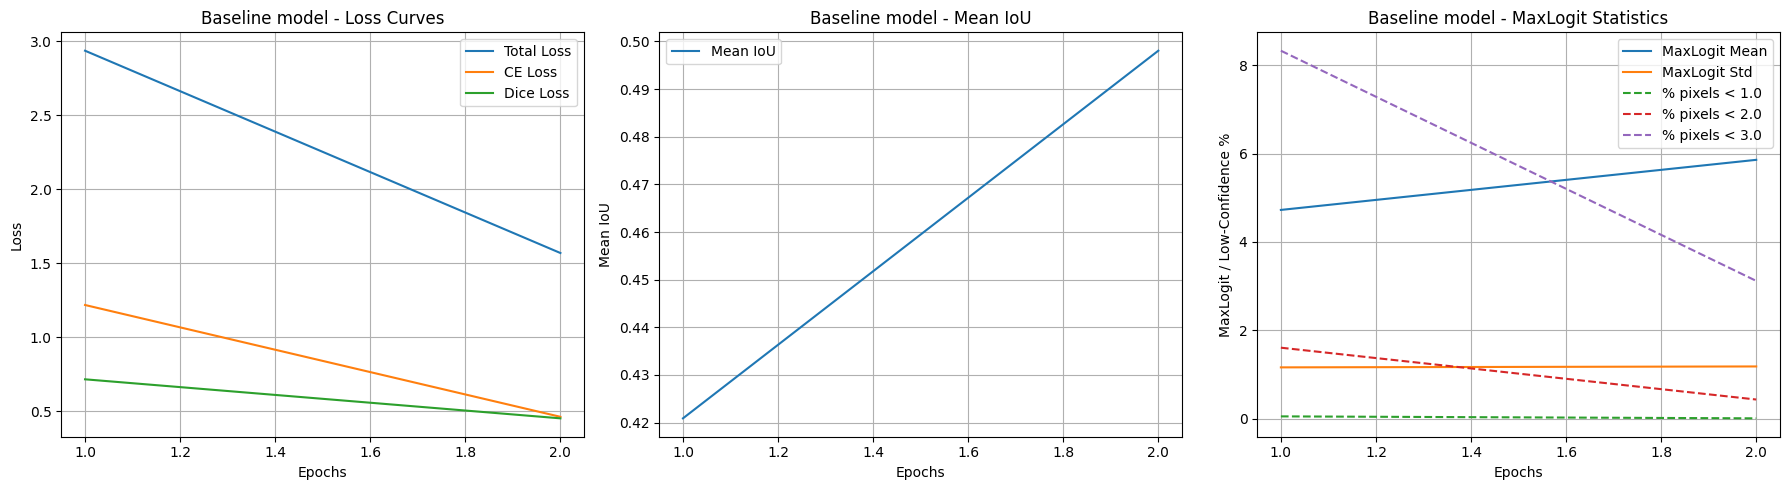

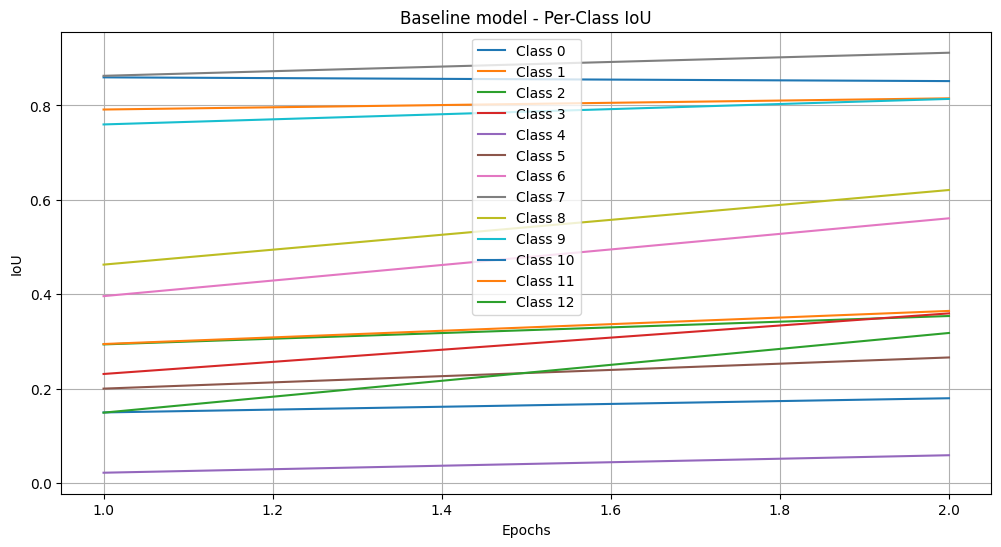

In [28]:
plot_training_curves(history, "Baseline model")

### 🧠 Evaluating model

Running the inference pipeline twice: **once for closed-set prediction** on unseen data (mIoU) and **again on open-set prediction** on unseen data (mIoU (known only), mIoU (including OOD), AUROC and AUPR (in and out))

In [30]:
results_closed = predict_dataloader(
    model,
    test_closed_loader,
    device,
    num_classes=NUM_CLASSES,      # 13 after shift (0..12)
    open_set=False,
    use_tiling=True, tile=1024, overlap=256,
    include_miou=True,
    viz_dir="./viz_closed",       # where to save side-by-side panels
    viz_every=20,                 # save every 20th batch (set 1 to save all)
    viz_limit=60,                 # cap total saved images
    denorm_fn=lambda x: denorm(x, mean=IMAGENET_MEAN, std=IMAGENET_STD),
    colors=COLORS                # your palette
)
print("Closed-set mIoU:", results_closed["mean_iou"])
print("Per-class IoU:", results_closed["per_class_iou"])

Closed-set mIoU: 0.6776599131329524
Per-class IoU: [0.8952138471934686, 0.8637069013441954, 0.6733305989906575, 0.5486328330281368, 0.23379137743778627, 0.4659244047427552, 0.6092846220331095, 0.9354139693386175, 0.7854045727081547, 0.8548333053714234, 0.6533575678513475, 0.7532931405139638, 0.537391730174762]


In [31]:
# OPEN-SET (GT OOD is class 13)
results_open = predict_dataloader(
    model,
    test_open_loader,
    device,
    num_classes=NUM_CLASSES,      # 13 known classes -> 0..12
    open_set=True,
    anomaly_id=NUM_CLASSES,       # 13 becomes OOD class index
    tau=2.0,
    use_tiling=True, tile=1024, overlap=256,
    include_miou=True,
    viz_dir="./viz_open",
    viz_every=10,
    viz_limit=80,
    denorm_fn=lambda x: denorm(x, mean=IMAGENET_MEAN, std=IMAGENET_STD),
    colors=COLORS
)

print("\n🔍 Open-set evaluation results:")
print(f"  • AUROC (MaxLogit):              {results_open.get('auroc_ood_maxlogit', float('nan')):.4f}")
print(f"  • AUPR-Out (OOD positive):       {results_open.get('aupr_out', float('nan')):.4f}")
print(f"  • AUPR-In  (ID positive):        {results_open.get('aupr_in', float('nan')):.4f}")
print(f"  • Mean IoU (known only):         {results_open.get('mean_iou_known', float('nan')):.4f}")
print(f"  • Mean IoU (including OOD):      {results_open.get('mean_iou_all', float('nan')):.4f}")

/tmp/ipython-input-3333944040.py:28: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(precision, recall))



🔍 Open-set evaluation results:
  • AUROC (MaxLogit):              0.8845
  • AUPR-Out (OOD positive):       0.1024
  • AUPR-In  (ID positive):        0.9975
  • Mean IoU (known only):         0.5323
  • Mean IoU (including OOD):      0.4773
📁 Visuals saved to ./viz_open and ./viz_closed
